**Dense** layer is a classic fully connected neural network layer : each input node is connected to each output node.

In **Dropout** layer the activations are set to zero for some random nodes. This is a way to prevent overfitting. A dropout in LSTM generates 4 different dropout masks, for creating different inputs for each of the different gates.

**Activation function** decides, whether a neuron should be activated or not by calculating weighted sum and further adding bias with it. Activation functions are useful because they add non-linearities into neural networks, allowing the neural networks to learn powerful operations.

**Conv2d** layer because our image data is two dimensional. Conv2D parameter is the numbers of filters that convolutional layers will learn from. 

**Dropout** is an approach to regularization to prevent overfitting in neural networks which helps reducing interdependent learning amongst the neurons.

**Max pooling 2D** downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

**Batch normalization** is a technique designed to automatically standardize the inputs to a layer in a deep learning neural network. 

**Flattening** is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer.

**Cross-entropy loss**, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. **Categorical crossentropy** is a loss function that is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories, and the model must decide which one.

**Regularization** is a set of techniques that can prevent overfitting in neural networks and thus improve the accuracy of a Deep Learning model when facing completely new or complex data from the problem domain.

**ImageDataGenerator** lets you augment your images in real-time while your model is still training.  It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more. 

The **shutil module** helps you automate copying files and directories. It saves the steps of opening, reading, writing and closing files when there is no actual processing.

**tqdm** is a library in Python which is used for creating Progress Meters or Progress Bars.

The **OS module** in Python provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc.

**IPython.core.display import display, HTML** to embed HTML into Ipython output.

In [1]:
import tensorflow as tf
from tensorflow import keras

#If you want the Keras modules you write to be compatible with both Theano and TensorFlow, you have to write them via the abstract Keras backend API.
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential #Sequential API is used to create models layer-by-layer. 
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

Look at an image to get the shape

In [2]:
imgpath=r'C:\Users\HP\Projects\Breast Cancer Images/10253/0/10253_idx5_x1001_y1001_class0.png'
img=cv2.imread(imgpath)
print (img.shape)

(50, 50, 3)


Define a function to return the class given the filepath

The **rfind()** method finds the last occurrence of the specified value. The rfind() method returns -1 if the value is not found.

In [3]:
def get_class(fpath):
    index1=fpath.rfind('_')
    c_ext=fpath[index1+1:]    
    index2=c_ext.rfind('.')
    klass=c_ext[:index2]
    if klass== 'class0':
        return 'healthy'
    else:
        return 'cancer'

Iterate through the folders to create a list of filepaths and associated labels

In [4]:
filepaths=[]
labels=[]
sdir=r'C:\Users\HP\Projects\Breast Cancer Images'
slist=os.listdir(sdir)
for s in slist:
    spath=os.path.join(sdir,s)
    clist=os.listdir(spath)
    for c in clist:        
        cpath=os.path.join(spath,c)
        flist=os.listdir(cpath)
        for f in flist:
            fpath=os.path.join(cpath,f)            
            filepaths.append(fpath) 
            if c=='0':
                labels.append('healthy')
            else:
                labels.append('cancer')
            
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  277524    labels:  277524


Create a dataframe with columns filepaths, labels, define the classes and look at class balance

In [5]:
#To create DataFrame from Dicts of series, dictionary can be passed to form a DataFrame. The resultant index is the union of all the series of passed indexed.
 

Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print(df.tail())
vcounts=df['labels'].value_counts()
print (vcounts)
vcounts=list(vcounts)
vmin=np.min(vcounts)
print (vmin)
classes=df['labels'].unique()
print (classes)
class_count=len(classes)

                                           filepaths   labels
0  C:\Users\HP\Projects\Breast Cancer Images\1025...  healthy
1  C:\Users\HP\Projects\Breast Cancer Images\1025...  healthy
2  C:\Users\HP\Projects\Breast Cancer Images\1025...  healthy
3  C:\Users\HP\Projects\Breast Cancer Images\1025...  healthy
4  C:\Users\HP\Projects\Breast Cancer Images\1025...  healthy
                                                filepaths  labels
277519  C:\Users\HP\Projects\Breast Cancer Images\9383...  cancer
277520  C:\Users\HP\Projects\Breast Cancer Images\9383...  cancer
277521  C:\Users\HP\Projects\Breast Cancer Images\9383...  cancer
277522  C:\Users\HP\Projects\Breast Cancer Images\9383...  cancer
277523  C:\Users\HP\Projects\Breast Cancer Images\9383...  cancer
healthy    198738
cancer      78786
Name: labels, dtype: int64
78786
['healthy' 'cancer']


Highly unbalanced dataset and too many samples - limit each class to have about 25000 samples

In [6]:
#Query the columns of a DataFrame with a boolean expression. The query string to evaluate. You can refer to variables in the environment by prefixing them with an '@' character like @a + b 

file_count = 25000
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1)) #sample() function returns a particular length list of items chosen from the sequence
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 25000 samples
print (len(df))

healthy    25000
cancer     25000
Name: labels, dtype: int64
50000


Create train, test, valid dataframes and generators

In [7]:
height=75
width=75
channels=3
batch_size=80
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

#ImageDataGenerator class ensures that the model receives new variations of the images at each epoch. But it only returns the transformed images and does not add it to the original corpus of images. 

def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True, vertical_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

#The flow_from_dataframe() allows to directly augment images by reading its name and target value from a dataframe.

train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

train samples:  45000   test samples:  2500  validation samples 2500
test batch size:  50   test steps:  50
Found 45000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


Create function to show some image examples

In [8]:
def show_image_samples(gen, class_names):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key        
    images,labels=next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

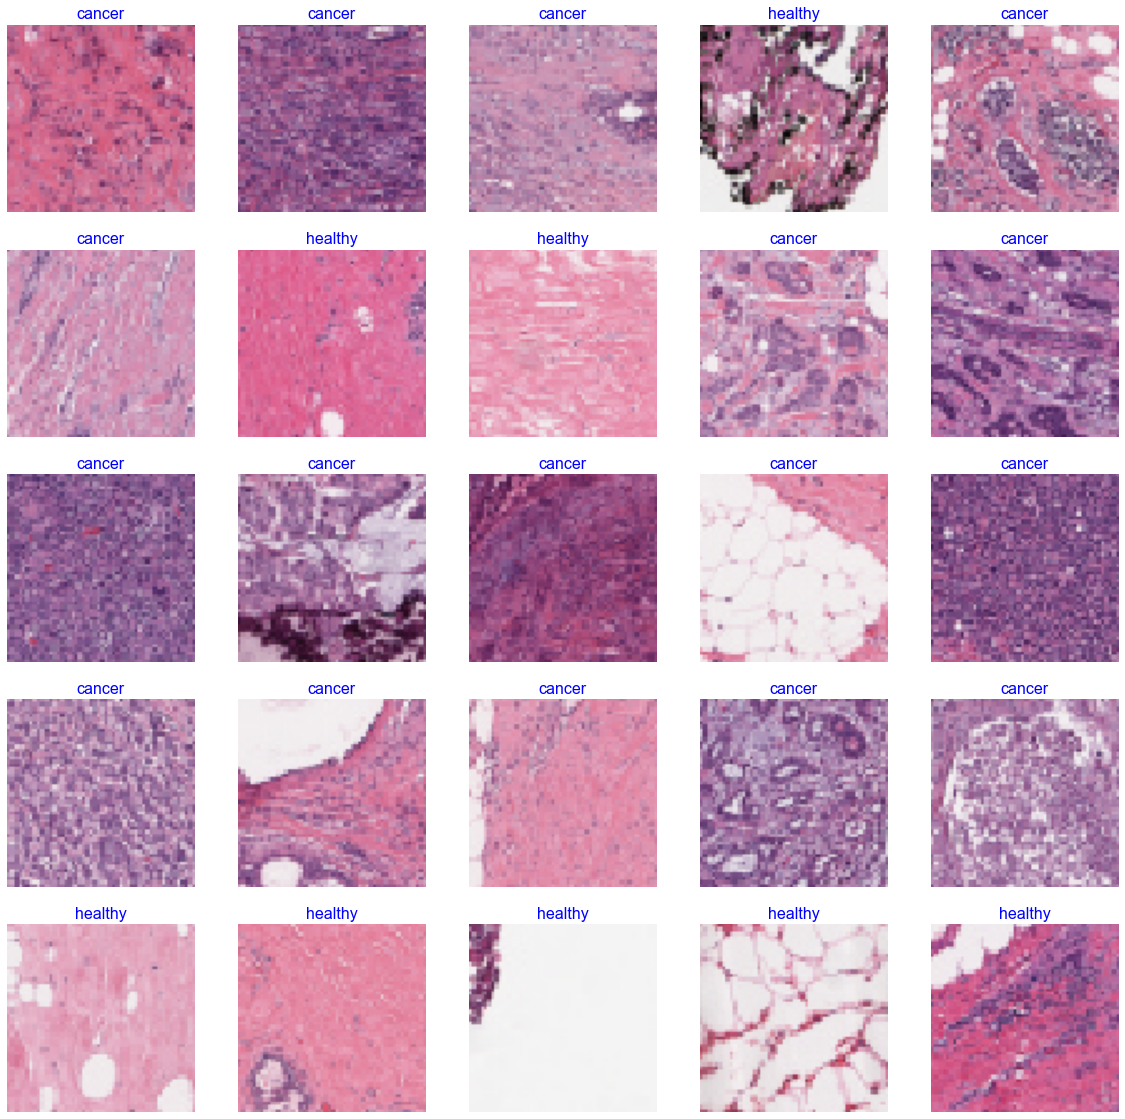

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [11]:
show_image_samples(test_gen, classes)
plt.figure(figsize=(5,5))

Define function to print text in RGB foreground and background colors

In [12]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

**Create the model**

In [13]:
model_name='InceptionResNetV2' 
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output 

#epsilon: Small float added to variance to avoid dividing by zero.
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)     
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)  
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)   
model=Model(inputs=base_model.input, outputs=output)   
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])         

219070464/219055592 [==============================] - 36s 0us/step


C:\Users\HP\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Create a subclass of callbacks to control learning rate and print training results for each epoch

In [14]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted  i.e. the number of epochs to wait before early stop if no progress on the validation set. 
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:60s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

Instantiate the custom callback

In [18]:
epochs = 6
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=False # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze,batches=train_steps, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing

 Starting training using base model InceptionResNetV2 training all layers 



Train the model

In [19]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /6      0.701   85.569   0.47756  87.520   0.00100  0.00100  accuracy  2622.86 loss:  0.70121 

 2 /6      0.426   87.053   0.40356  87.120   0.00100  0.00100  accuracy  2557.67 loss:  0.42586 

 3 /6      0.357   88.309   0.99468  85.920   0.00100  0.00100  accuracy  2586.67 loss:  0.35660 

 4 /6      0.319   89.489   0.51367  87.480   0.00100  0.00100  accuracy  2723.38 loss:  0.31895 

 5 /6      0.282   91.058   0.48562  86.760   0.00100  0.00050  val_loss  2755.45 s:  0.28180 

 6 /6      0.228   93.531   0.38973  87.160   0.00050  0.00050  val_loss  2558.43 loss:  0.22767 



 Define function to plot the training data

In [20]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

Plot the data and then evaluate model on the test set

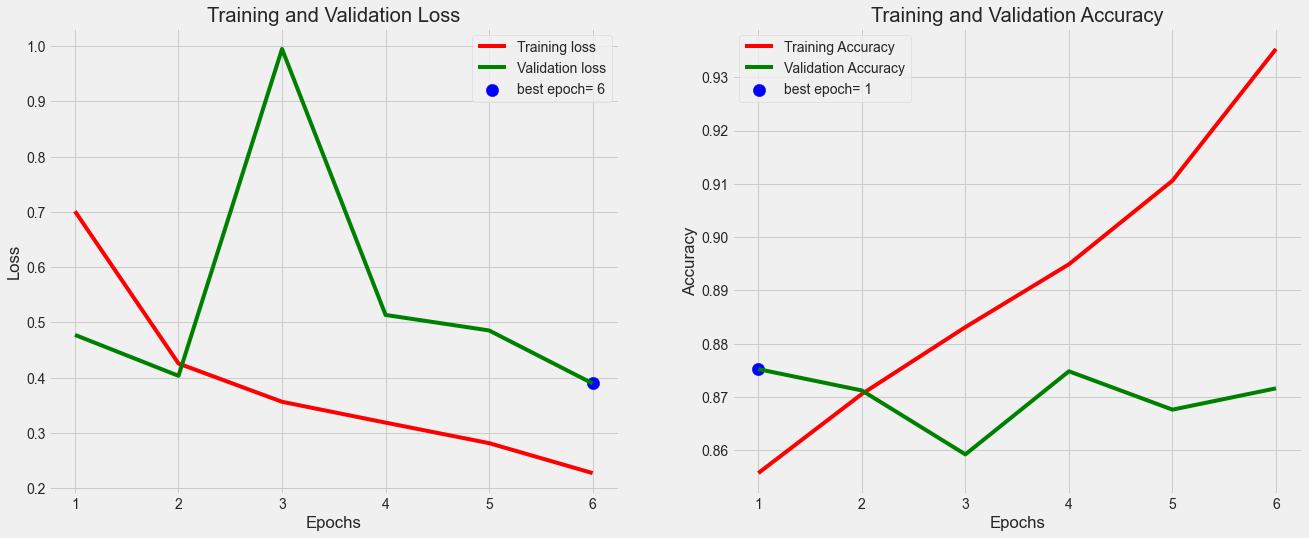

50/50 [==============================] - 22s 441ms/step - loss: 0.4016 - accuracy: 0.8672
Model accuracy on test set: 86.72000169754028



In [21]:
tr_plot(history, 0)
acc=model.evaluate(test_gen, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print_in_color(msg, (0,255,0), (55,65,80))

Define function to generate the confusion matrix and classification report

In [22]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

Save the model

In [23]:
save_dir=r'./'
subject='cancer'
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

Make predictions on test set and generate confusion matrix and classification report

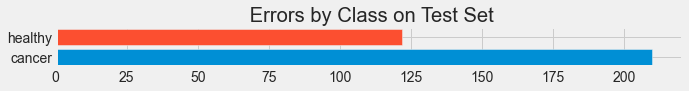

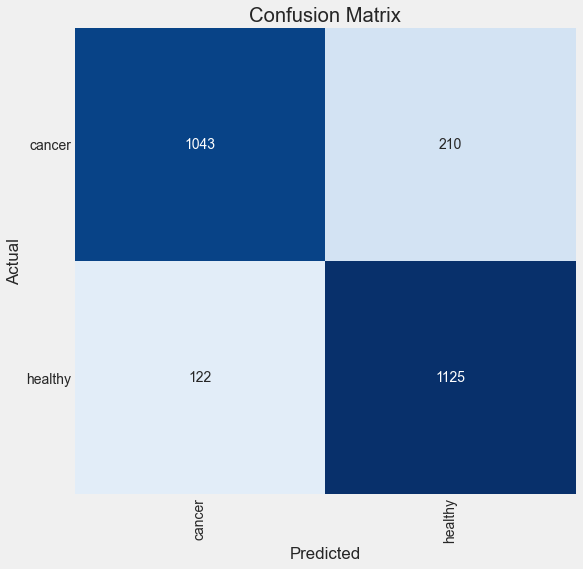

Classification Report:
----------------------
               precision    recall  f1-score   support

      cancer       0.90      0.83      0.86      1253
     healthy       0.84      0.90      0.87      1247

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500



In [24]:
print_code=0
preds=model.predict(test_gen, steps=test_steps) 
print_info( test_gen, preds, print_code, save_dir, subject )  

In [30]:
preds.shape

(2500, 2)

In [31]:
print(preds)
classes_x=np.argmax(preds,axis=1)

[[0.02595129 0.97404873]
 [0.01976305 0.98023695]
 [0.07647716 0.92352283]
 ...
 [0.01918845 0.9808115 ]
 [0.8851767  0.11482332]
 [0.01889721 0.98110276]]


In [32]:
preds = preds[:,0]

In [35]:
fnames = test_gen.filenames ## fnames is all the filenames/samples used in testing
errors = np.where(preds != test_gen.classes)[0] ## misclassifications done on the test data 
for i in errors:
    print(fnames[i]) 

C:\Users\HP\Projects\Breast Cancer Images\12626\1\12626_idx5_x751_y2051_class1.png
C:\Users\HP\Projects\Breast Cancer Images\12954\0\12954_idx5_x1051_y1101_class0.png
C:\Users\HP\Projects\Breast Cancer Images\9382\0\9382_idx5_x701_y501_class0.png
C:\Users\HP\Projects\Breast Cancer Images\10274\1\10274_idx5_x1901_y1051_class1.png
C:\Users\HP\Projects\Breast Cancer Images\12901\1\12901_idx5_x1751_y1001_class1.png
C:\Users\HP\Projects\Breast Cancer Images\15840\0\15840_idx5_x2251_y951_class0.png
C:\Users\HP\Projects\Breast Cancer Images\12817\0\12817_idx5_x3051_y551_class0.png
C:\Users\HP\Projects\Breast Cancer Images\12826\0\12826_idx5_x1801_y2201_class0.png
C:\Users\HP\Projects\Breast Cancer Images\8951\0\8951_idx5_x551_y1451_class0.png
C:\Users\HP\Projects\Breast Cancer Images\10254\0\10254_idx5_x1551_y851_class0.png
C:\Users\HP\Projects\Breast Cancer Images\9290\0\9290_idx5_x1401_y1601_class0.png
C:\Users\HP\Projects\Breast Cancer Images\12880\1\12880_idx5_x851_y1201_class1.png
C:\Use

C:\Users\HP\Projects\Breast Cancer Images\12934\1\12934_idx5_x3151_y1951_class1.png
C:\Users\HP\Projects\Breast Cancer Images\16550\0\16550_idx5_x1151_y651_class0.png
C:\Users\HP\Projects\Breast Cancer Images\14157\1\14157_idx5_x1801_y1651_class1.png
C:\Users\HP\Projects\Breast Cancer Images\9226\1\9226_idx5_x1851_y2001_class1.png
C:\Users\HP\Projects\Breast Cancer Images\10302\1\10302_idx5_x501_y1301_class1.png
C:\Users\HP\Projects\Breast Cancer Images\16553\1\16553_idx5_x1251_y1101_class1.png
C:\Users\HP\Projects\Breast Cancer Images\10274\1\10274_idx5_x1751_y801_class1.png
C:\Users\HP\Projects\Breast Cancer Images\9075\0\9075_idx5_x2401_y2301_class0.png
C:\Users\HP\Projects\Breast Cancer Images\16166\1\16166_idx5_x1801_y1801_class1.png
C:\Users\HP\Projects\Breast Cancer Images\14154\0\14154_idx5_x1051_y251_class0.png
C:\Users\HP\Projects\Breast Cancer Images\13916\1\13916_idx5_x1551_y851_class1.png
C:\Users\HP\Projects\Breast Cancer Images\12823\1\12823_idx5_x3251_y1251_class1.png
C

In [36]:
fnames1 = test_gen.filenames ## fnames is all the filenames/samples used in testing
corrects = np.where(preds == test_gen.classes)[0] ## misclassifications done on the test data 
for i in corrects:
    print(fnames1[i])

In [37]:
 print(fnames1[i])

C:\Users\HP\Projects\Breast Cancer Images\9383\0\9383_idx5_x751_y451_class0.png


In [40]:
len(test_gen)

50

In [48]:
file_names=test_gen.filenames  # save list of test files names to be used later
tlabels=test_gen.labels # save test labels to be used later
class_dict=test_gen.class_indices

# code below determines test batch size and test steps
# so you go through the test images exactly once
length=len(file_names) # determine number of images

# make predictions
preds=model.predict(test_gen, verbose=1, steps= len(test_gen))

new_dict={} 
for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value=class_dict[key]
    new_dict[value]=key
print('PREDICTED CLASS     TRUE CLASS              FILENAME                      ERROR STATUS' ) # adjust spacing based on your class names
error_list=[] # empty list to store if the prediction was correct or not
error_file_list=[]
for i, p in enumerate(preds):
    pred_index=np.argmax(p) # get the index that has the highest probability
    if pred_index == tlabels[i]:
        error_list.append ('No') # correct classification
    else:
        error_list.append('Yes')
        error_file_list.append(file_names[i])
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[tlabels[i]] # use the test label to get the true class of the test file
    file=file_names[i]
    print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {error_list[i]}')


50/50 [==============================] - 27s 522ms/step
PREDICTED CLASS     TRUE CLASS              FILENAME                      ERROR STATUS
    healthy          cancer        C:\Users\HP\Projects\Breast Cancer Images\12626\1\12626_idx5_x751_y2051_class1.png   Yes
    healthy          healthy       C:\Users\HP\Projects\Breast Cancer Images\12954\0\12954_idx5_x1051_y1101_class0.png   No
    healthy          healthy       C:\Users\HP\Projects\Breast Cancer Images\9382\0\9382_idx5_x701_y501_class0.png   No
    healthy          cancer        C:\Users\HP\Projects\Breast Cancer Images\10274\1\10274_idx5_x1901_y1051_class1.png   Yes
    healthy          cancer        C:\Users\HP\Projects\Breast Cancer Images\12901\1\12901_idx5_x1751_y1001_class1.png   Yes
    healthy          healthy       C:\Users\HP\Projects\Breast Cancer Images\15840\0\15840_idx5_x2251_y951_class0.png   No
    healthy          healthy       C:\Users\HP\Projects\Breast Cancer Images\12817\0\12817_idx5_x3051_y551_class0.pn

    healthy          cancer        C:\Users\HP\Projects\Breast Cancer Images\9073\1\9073_idx5_x951_y951_class1.png   Yes
    cancer           cancer        C:\Users\HP\Projects\Breast Cancer Images\14211\1\14211_idx5_x2051_y1351_class1.png   No
    cancer           cancer        C:\Users\HP\Projects\Breast Cancer Images\15473\1\15473_idx5_x1501_y1851_class1.png   No
    cancer           cancer        C:\Users\HP\Projects\Breast Cancer Images\12880\1\12880_idx5_x1401_y1001_class1.png   No
    healthy          healthy       C:\Users\HP\Projects\Breast Cancer Images\14155\0\14155_idx5_x3851_y651_class0.png   No
    cancer           cancer        C:\Users\HP\Projects\Breast Cancer Images\12935\1\12935_idx5_x1901_y1101_class1.png   No
    healthy          cancer        C:\Users\HP\Projects\Breast Cancer Images\14192\1\14192_idx5_x401_y1151_class1.png   Yes
    cancer           cancer        C:\Users\HP\Projects\Breast Cancer Images\14155\1\14155_idx5_x2601_y1851_class1.png   No
    healthy 